In [ ]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Flatten, Dense, Dropout, Conv2DTranspose, Concatenate, Reshape
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import callbacks
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import math
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями
from google.colab import drive
import datetime

In [ ]:
# Монтируем наш Google-диск
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Формируем датасет из файла
db_file   = '/content/drive/MyDrive/Colab\ Notebooks/Machine_learning/Images/4_Functional_network_TODO/cars.zip' # Файл с датасетом машин
db        = '/content/cars'

# Переменная для перевода в вероятности (One Hot Encoding)
labels = {} # Используем словарь
labels['Ferrari']  = [1,0,0]
labels['Mercedes'] = [0,1,0]
labels['Renault']  = [0,0,1]

In [ ]:
# Удалить директорию, куда разархивируем датасет
!rm -rf {db}

In [ ]:
# Распаковываем наш архив в пространство Colab
!unzip -q {db_file} -d {db}

In [ ]:
# Знакомая нам функция загрузки изображения
def load_image(file_name):
  image = Image.open(file_name) # Загружаем изображение из файла

  image = image.convert('RGB')  # Приводим изображение к режиму черно-белого изображения 8 бит (0 ... 256) # Разве к ЧБ?

  image_width  = image.size[0]  # Получаем ширину
  image_height = image.size[1]  # Получаем высоту

  image_data = image.getdata()          # Получаем данные картинки
  image_data = np.array(image_data)     # Преобразуем в np массив

  image = image_data.reshape(image_height, image_width, 3)  # Решейпим изображение для цветного варианта
  if (image_height != 108) | (image_width != 192): # Ругаемся на изображение не удовлетворяющее размерам
    print(file_name, "!!!!!!!!!!!!!!")

  return image # Возвращаем трехмерный массив с пикселями

In [ ]:
# Формируем наш датасет

image_list = [] # Список всех изображений

for label in labels.keys():
  flist = os.listdir(db + "/" + label)
  print (label, '->', len(flist), 'изображений') # Сколько файлов в каждой папке с машинами

  # Формируем список всех изобажений с расширением .png
  for image_name in flist:
    if ".png" not in image_name: # Сохраняем только изображения с расширением .png
      continue
    image_path = db + "/" + label + "/" + image_name
    image_list.append(image_path)

Ferrari -> 1090 изображений
Mercedes -> 1161 изображений
Renault -> 1180 изображений


In [ ]:
print()
print("Пример названий файлов в массиве:")
print(image_list[0:3])

# перемешаем значения в датасете
random.shuffle(image_list)

print()
print("Пример названий файлов в массиве после перемешивания:")
print(image_list[0:3])
print()

# Формирование обучающей выборки и ответов
x_train = []
y_train = []

c = 1 # номер загружаемого изображения
flen = len(image_list) # кол. всех изображений
for image_name in image_list:
  img = load_image(image_name) # Получаем массив изображения
  label = image_name.split('/')[3] #Получаем верный ответ на изображение из пути к нему
  x_train.append(img)
  y_train.append(labels[label])
  print(c, flen, image_name)
  c += 1

x_train = np.array(x_train)
y_train = np.array(y_train)


Пример названий файлов в массиве:
['/content/cars/Ferrari/car_Ferrari__925.png', '/content/cars/Ferrari/car_Ferrari__139.png', '/content/cars/Ferrari/car_Ferrari__142.png']

Пример названий файлов в массиве после перемешивания:
['/content/cars/Mercedes/car__452.png', '/content/cars/Ferrari/car_Ferrari__190.png', '/content/cars/Mercedes/car__98.png']

1 3431 /content/cars/Mercedes/car__452.png
2 3431 /content/cars/Ferrari/car_Ferrari__190.png
3 3431 /content/cars/Mercedes/car__98.png
4 3431 /content/cars/Mercedes/car__1063.png
5 3431 /content/cars/Renault/car__548.png
6 3431 /content/cars/Renault/car__752.png
7 3431 /content/cars/Renault/car__747.png
8 3431 /content/cars/Ferrari/car_Ferrari__1307.png
9 3431 /content/cars/Mercedes/car__315.png
10 3431 /content/cars/Ferrari/car_Ferrari__184.png
11 3431 /content/cars/Mercedes/car__1286.png
12 3431 /content/cars/Mercedes/car__693.png
13 3431 /content/cars/Renault/car__757.png
14 3431 /content/cars/Mercedes/car__1217.png
15 3431 /content/ca

In [ ]:
# Выведем размерности нашей обучающей выборки (вопросов и верных ответов)
print("Размерность x_train", x_train.shape)
print()
print("Размерность y_train", y_train.shape)

Размерность x_train (3431, 108, 192, 3)

Размерность y_train (3431, 3)


In [ ]:
# Сформируеем проверочную, обучающую и тестовую выборки из обучающей выборки (всех изображений) и ответов на них

# Проверочная выборка
x_val = x_train[3000:3327]
y_val = y_train[3000:3327]

# Тестовая выборка
x_test = x_train[3327:]
y_test = y_train[3327:]

# Обучающая выборка
x_train = x_train[0:3000]
y_train = y_train[0:3000]

print("Обучающая выборка:")
print(x_train.shape)
print(y_train.shape)
print()

print("Проверочная выборка:")
print(x_val.shape)
print(y_val.shape)
print()

print("Тестовая выборка:")
print(x_test.shape)
print(y_test.shape)

Обучающая выборка:
(3000, 108, 192, 3)
(3000, 3)

Проверочная выборка:
(327, 108, 192, 3)
(327, 3)

Тестовая выборка:
(104, 108, 192, 3)
(104, 3)


Объектная модель нейросети

In [ ]:
# задаём batch_size
batch_size = 8 

# Создаем последовательную модель
model = Sequential()

model.add(BatchNormalization(input_shape=(108, 192, 3), name="bn1"))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', name="Conv2D-layer1"))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', name="Conv2D-layer2"))
model.add(MaxPooling2D(pool_size=(2, 2), name="mp2D-layer1"))
model.add(Dropout(0.25, name="Dropout-layer1"))

model.add(BatchNormalization(name = "bn2"))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name = "Conv2D-layer3"))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name = "Conv2D-layer4"))
model.add(MaxPooling2D(pool_size=(2, 2), name="mp2D-layer2"))
model.add(Dropout(0.25, name="Dropout-layer2"))

model.add(BatchNormalization(name = "bn3"))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name = "Conv2D-layer5"))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name = "Conv2D-layer6"))
model.add(MaxPooling2D(pool_size=(2, 2), name="mp2D-layer3"))
model.add(Dropout(0.25, name="Dropout-layer3"))

# Слой преобразования данных из 2D представления в плоское
model.add(Flatten(name="flatten"))
# Выходной полносвязный классифицирующий слой
model.add(Dense(3, activation='softmax', name = "labels")) # 3 - количество возможных ответов

# Компилируем сеть
#model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])
model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bn1 (BatchNormalization)     (None, 108, 192, 3)       12        
_________________________________________________________________
Conv2D-layer1 (Conv2D)       (None, 108, 192, 32)      896       
_________________________________________________________________
Conv2D-layer2 (Conv2D)       (None, 108, 192, 32)      9248      
_________________________________________________________________
mp2D-layer1 (MaxPooling2D)   (None, 54, 96, 32)        0         
_________________________________________________________________
Dropout-layer1 (Dropout)     (None, 54, 96, 32)        0         
_________________________________________________________________
bn2 (BatchNormalization)     (None, 54, 96, 32)        128       
_________________________________________________________________
Conv2D-layer3 (Conv2D)       (None, 54, 96, 64)        1

Epoch 1/20
375/375 [==============================] - 48s 46ms/step - loss: 1.1002 - accuracy: 0.4770 - val_loss: 0.9904 - val_accuracy: 0.5229
Epoch 2/20
375/375 [==============================] - 17s 44ms/step - loss: 0.9424 - accuracy: 0.5393 - val_loss: 1.1519 - val_accuracy: 0.4251
Epoch 3/20
375/375 [==============================] - 17s 44ms/step - loss: 0.8997 - accuracy: 0.5817 - val_loss: 0.9544 - val_accuracy: 0.5474
Epoch 4/20
375/375 [==============================] - 17s 44ms/step - loss: 0.8814 - accuracy: 0.5950 - val_loss: 0.9720 - val_accuracy: 0.5382
Epoch 5/20
375/375 [==============================] - 17s 45ms/step - loss: 0.8363 - accuracy: 0.6250 - val_loss: 0.9246 - val_accuracy: 0.5535
Epoch 6/20
375/375 [==============================] - 17s 44ms/step - loss: 0.8143 - accuracy: 0.6320 - val_loss: 0.8817 - val_accuracy: 0.6208
Epoch 7/20
375/375 [==============================] - 17s 45ms/step - loss: 0.7768 - accuracy: 0.6667 - val_loss: 0.9787 - val_accuracy:

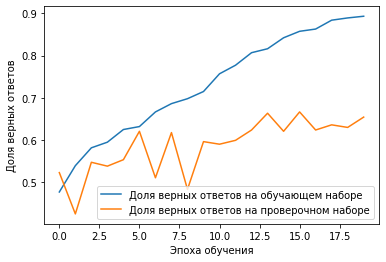

In [ ]:
# Обучаем сеть на выборках (x_train, y_train) 
history = model.fit(x_train, y_train, 
# Размер батча = через сколько обработанных изображений произойдёт смена весов
                    batch_size=batch_size, 
# Количество эпох = количеству раз, сколько обработаются все изображения с разными весами.
                    epochs=20,
# Используем данные тестовых выборок, чтобы видеть прогресс обучения на данных, на которых н.с. не учили.
                    validation_data=(x_val, y_val), 
# Вербозный режим – как будет отображаться инфа об обучении. 1 = шкала прогресса
                    verbose=1)

# Возвращаемый объект "history" содержит значения потерь и метрик во время обучения

# Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Функциональный метод

In [ ]:
img_input = Input((108, 192, 3))

# Первая ветка
x = Conv2D(64, (3, 3), padding='same', activation='relu')(img_input) # 64 - Формируем признаки понемногу
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = MaxPooling2D()(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = MaxPooling2D()(x)

x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = MaxPooling2D()(x)

# Вторая ветка
y = Conv2D(128, (6, 6), padding='same')(img_input) # 128 - Формируем сразу много признаков
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Dropout(0.2)(y)
y = MaxPooling2D()(y)

y = Conv2D(256, (6, 6), padding='same')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Dropout(0.2)(y)
y = MaxPooling2D(pool_size=(4,4))(y)

# Объединяем ветки
a = concatenate([x,y])

a = Conv2D(256, (4, 4), padding='same')(a)
a = Flatten()(a)
a = Dense(3, activation='softmax')(a)

model_func = Model(img_input, a)
model_func.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

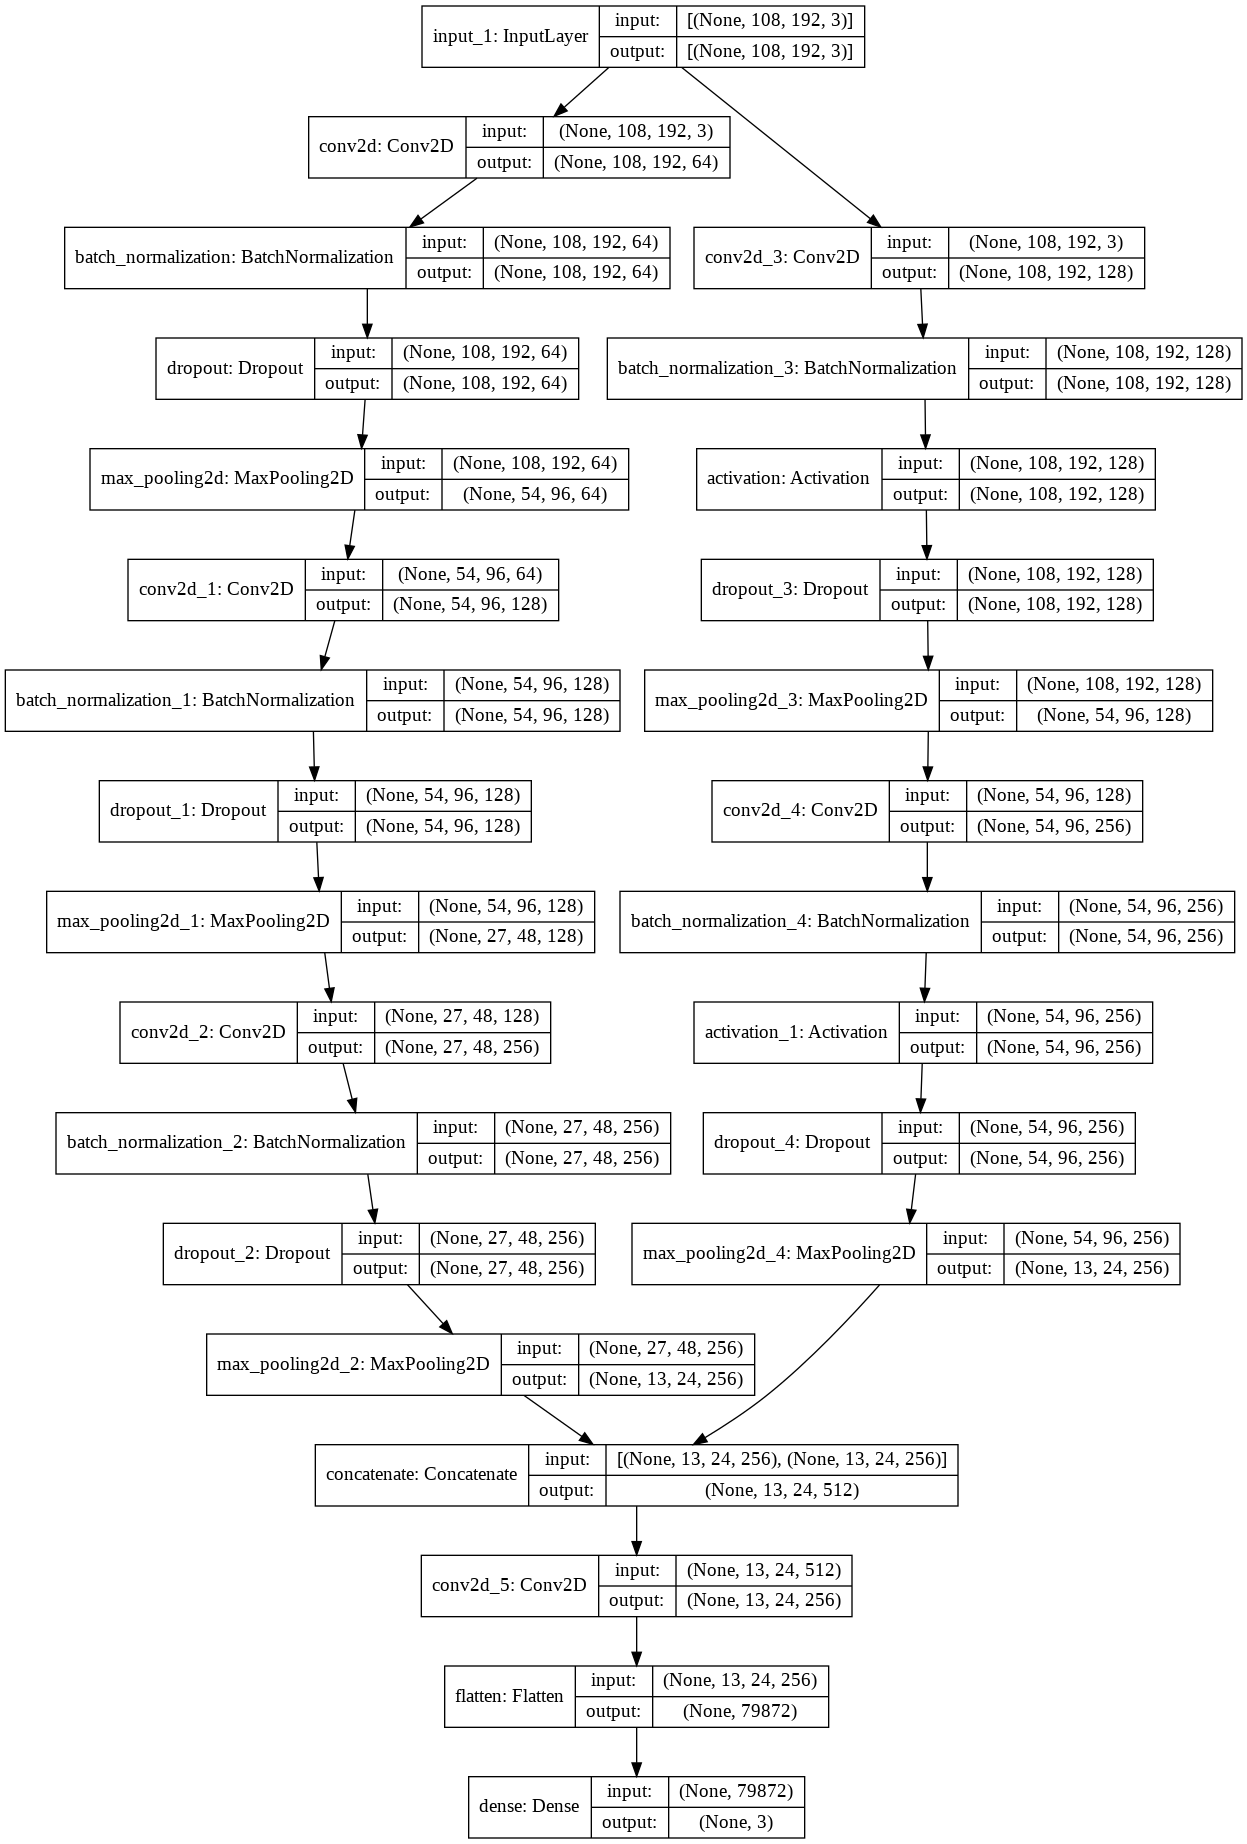

In [ ]:
utils.plot_model(model_func, 'func_model.png', show_shapes=True)

Epoch 1/20
375/375 [==============================] - 108s 281ms/step - loss: 34.9923 - accuracy: 0.4683 - val_loss: 28.6698 - val_accuracy: 0.4434
Epoch 2/20
375/375 [==============================] - 106s 283ms/step - loss: 6.6681 - accuracy: 0.5407 - val_loss: 3.6558 - val_accuracy: 0.5107
Epoch 3/20
375/375 [==============================] - 104s 277ms/step - loss: 2.4635 - accuracy: 0.6157 - val_loss: 3.0583 - val_accuracy: 0.5627
Epoch 4/20
375/375 [==============================] - 104s 277ms/step - loss: 2.0274 - accuracy: 0.6467 - val_loss: 4.7744 - val_accuracy: 0.5382
Epoch 5/20
375/375 [==============================] - 104s 277ms/step - loss: 1.6908 - accuracy: 0.6740 - val_loss: 2.2444 - val_accuracy: 0.5810
Epoch 6/20
375/375 [==============================] - 104s 277ms/step - loss: 0.9206 - accuracy: 0.7603 - val_loss: 2.0452 - val_accuracy: 0.5994
Epoch 7/20
375/375 [==============================] - 104s 277ms/step - loss: 0.7239 - accuracy: 0.7923 - val_loss: 2.6655

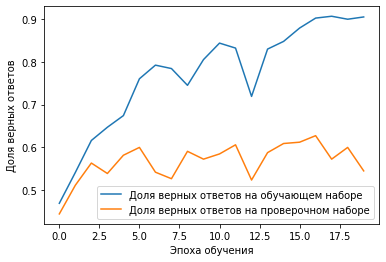

In [ ]:
# Обучаем сеть на наших данных
history = model_func.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=20,
                    validation_data=(x_val, y_val),
                    verbose=1)

# Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()